# Import the necessary libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score
from keras import initializers
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

seed = 16
np.random.seed(seed)

C:\Users\AHuang\Anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Clean and cheat samples, total')

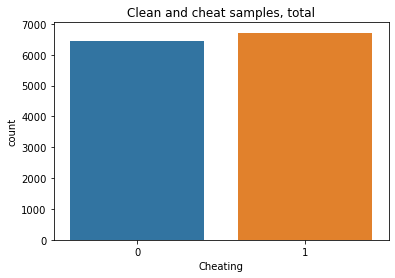

In [100]:
df = pd.read_csv('train.csv', header=None, delimiter=',',encoding='latin-1')

sb.countplot(df[0])
plt.xlabel('Cheating')
plt.title('Clean and cheat samples, total')

In [101]:
def extract_features(df):
    data = df.to_numpy()
    
    Y = data[:, 0]
    X = data[:, 1:]
    
    # Only us some features
    features = [0, 1, 2, 3, 4, 5, 6]
    num_features = len(features)
    idxs = []
    
    for i in range(X.shape[1]):
        if (i >= 7 * 48):
            continue
        if (i % 7) in features:
            idxs.append(i)
            
    num_samples = len(idxs) // num_features
    X = X[:, idxs]
    X = X.reshape(-1, num_samples, num_features)
    
    return X, Y
    

def split(X, Y):
    X_train, X_val, Y_train, Y_val = [], [], [], []
    
    # Split training at test set, in chunks to prevent information leak
    chunk_size = 100
    val_fraction = 0.2
    chunks = [[*range(chunk_size * i, chunk_size * (i+1))] for i in range(Y.shape[0]//chunk_size)]
    chunks.append([*range(chunk_size * (Y.shape[0]//chunk_size - 1), Y.shape[0] -1)])
    np.random.shuffle(chunks)
    
    for i, chunk in enumerate(chunks):
        if i < len(chunks) * 0.2:
            X_val.extend(X[chunk])
            Y_val.extend(Y[chunk])
        else:
            X_train.extend(X[chunk])
            Y_train.extend(Y[chunk])
            
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)
    
    return X_train, Y_train, X_val, Y_val

In [102]:
X_train, Y_train, X_val, Y_val = split(*extract_features(df))

C:\Users\AHuang\Anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Clean and cheat samples, validation')

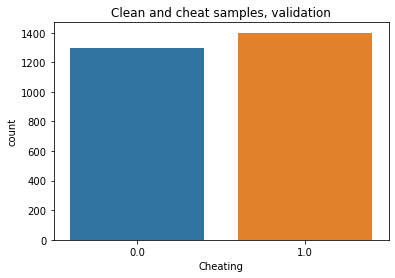

In [103]:
sb.countplot(Y_val)
plt.xlabel('Cheating')
plt.title('Clean and cheat samples, validation')

In [19]:
#values = np.moveaxis(X_train, 2, 0)
#values = values.reshape(values.shape[0], -1)
#means = np.mean(values, axis=1)
#stds = np.std(values, axis=1)
#print(means)
#print(stds)
#means = np.array([0, 0, 0, 0, 0, 0, 0]) # Vectors should be 0 mean
#stds = np.array([1, 1, 1, 1, 1, 1, 1])
#
#X_train_norm = np.moveaxis(X_train, 2, 0)
#X_train_norm = X_train_norm.reshape(X_train.shape[2], -1)
#means_repeat = np.repeat(means[:, np.newaxis], X_train_norm.shape[1], axis=1)
#stds_repeat = np.repeat(stds[:, np.newaxis], X_train_norm.shape[1], axis=1)
#X_train_norm -= means_repeat
#X_train_norm /= stds_repeat
#X_train_norm = X_train_norm.reshape(X_train.shape[2], X_train.shape[0], -1)
#X_train_norm = np.moveaxis(X_train_norm, 0, 2)
#X_train = X_train_norm
#
#X_val_norm = np.moveaxis(X_val, 2, 0)
#X_val_norm = X_val_norm.reshape(X_val.shape[2], -1)
#means_repeat = np.repeat(means[:, np.newaxis], X_val_norm.shape[1], axis=1)
#stds_repeat = np.repeat(stds[:, np.newaxis], X_val_norm.shape[1], axis=1)
#X_val_norm -= means_repeat
#X_val_norm /= stds_repeat
#X_val_norm = X_val_norm.reshape(X_val.shape[2], X_val.shape[0], -1)
#X_val_norm = np.moveaxis(X_val_norm, 0, 2)
#X_val = X_val_norm

In [104]:
def RNN():
    inputs = Input(name='inputs',shape=[num_samples, num_features])
   
    layer = LSTM(
        512,
        return_sequences=False,
        kernel_regularizer=regularizers.l2(1e-3)
    )(inputs)
    #layer = Bidirectional(LSTM(128, return_sequences=False))(inputs)
    #layer = Bidirectional(LSTM(128))(layer)
    
    layer = Dense(512, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [105]:
model = RNN()
model.summary()
opt = RMSprop(learning_rate=6e-4)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 48, 7)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1064960   
_________________________________________________________________
FC1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
out (Dense)                  (None, 1)                 513       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                

In [107]:
model.fit(
    X_train,
    Y_train,
    batch_size=1600,
    epochs=100,
    validation_data = (X_val, Y_val))
    #callbacks=[EarlyStopping(monitor='val_accuracy', patience=50)])

Epoch 1/100
7/7 [==============================] - 1s 149ms/step - loss: 0.6042 - accuracy: 0.6785
Epoch 2/100
7/7 [==============================] - 1s 143ms/step - loss: 0.5957 - accuracy: 0.6875
Epoch 3/100
7/7 [==============================] - 1s 163ms/step - loss: 0.5821 - accuracy: 0.7031
Epoch 4/100
7/7 [==============================] - 1s 148ms/step - loss: 0.5929 - accuracy: 0.6877
Epoch 5/100
7/7 [==============================] - 1s 146ms/step - loss: 0.5744 - accuracy: 0.7051
Epoch 6/100
7/7 [==============================] - 1s 140ms/step - loss: 0.5547 - accuracy: 0.7235
Epoch 7/100
7/7 [==============================] - 1s 140ms/step - loss: 0.5668 - accuracy: 0.7096
Epoch 8/100
7/7 [==============================] - 1s 142ms/step - loss: 0.5383 - accuracy: 0.7290
Epoch 9/100
7/7 [==============================] - 1s 153ms/step - loss: 0.5771 - accuracy: 0.7019
Epoch 10/100
7/7 [==============================] - 1s 141ms/step - loss: 0.5225 - accuracy: 0.7488
Epoch 11/

7/7 [==============================] - 1s 150ms/step - loss: 0.0175 - accuracy: 0.9998
Epoch 81/100
7/7 [==============================] - 1s 148ms/step - loss: 0.0155 - accuracy: 0.9999
Epoch 82/100
7/7 [==============================] - 1s 150ms/step - loss: 0.0143 - accuracy: 0.9999
Epoch 83/100
7/7 [==============================] - 1s 147ms/step - loss: 0.2234 - accuracy: 0.9313
Epoch 84/100
7/7 [==============================] - 1s 158ms/step - loss: 0.0493 - accuracy: 0.9895
Epoch 85/100
7/7 [==============================] - 1s 160ms/step - loss: 0.0208 - accuracy: 0.99920s - loss: 0.0228 - accu
Epoch 86/100
7/7 [==============================] - 1s 152ms/step - loss: 0.0159 - accuracy: 0.9999
Epoch 87/100
7/7 [==============================] - 1s 149ms/step - loss: 0.0142 - accuracy: 1.0000
Epoch 88/100
7/7 [==============================] - 1s 146ms/step - loss: 0.0148 - accuracy: 0.9992
Epoch 89/100
7/7 [==============================] - 1s 145ms/step - loss: 0.2342 - accura

In [108]:
probabilities = model.predict(X_val)
print('ROC AUC: {:.3f}\n'.format(roc_auc_score(Y_val, probabilities)))

boundary = 0.5
pred = (probabilities > boundary).astype(int)
print('Metrics with {:.2f} decision boundary:'.format(boundary))

conf = confusion_matrix(Y_val, pred)
print("Confusion matrix:\n", conf)
print('Accuracy: {:.3f}'.format((conf[1, 1] + conf[0, 0]) / np.sum(conf)))
print('Sensitivity : {:.3f}'.format(conf[1, 1] / (conf[1, 1] + conf[1, 0])))
print('Specificity : {:.3f}'.format(conf[0, 0] / (conf[0, 0] + conf[0, 1])))

ROC AUC: 0.692

Metrics with 0.50 decision boundary:
Confusion matrix:
 [[898 402]
 [554 846]]
Accuracy: 0.646
Sensitivity : 0.604
Specificity : 0.691


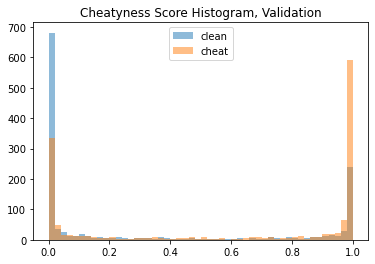

In [109]:
clean_scores = []
cheat_scores = []

probabilities = model.predict(X_val)

for i, p in enumerate(probabilities):
    if (Y_val[i]) == 0:
        clean_scores.append(p.item())
    else:
        cheat_scores.append(p.item())
        
plt.hist(clean_scores, label='clean', bins=50, alpha=0.5)
plt.hist(cheat_scores, label='cheat', bins=50, alpha=0.5)
plt.title("Cheatyness Score Histogram, Validation")
plt.legend(loc = 'upper center')
plt.show()

In [116]:
df_test = pd.read_csv('other.csv', header=None, delimiter=',',encoding='latin-1')
X_test, Y_test = extract_features(df_test)

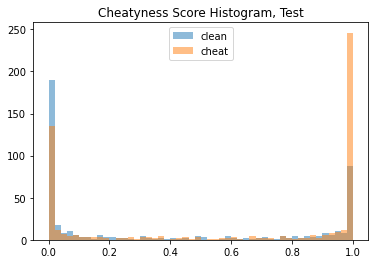

In [117]:
clean_scores = []
cheat_scores = []

probabilities = model.predict(X_test)

for i, p in enumerate(probabilities):
    if (Y_test[i]) == 0:
        clean_scores.append(p.item())
    else:
        cheat_scores.append(p.item())
        
plt.hist(clean_scores, label='clean', bins=50, alpha=0.5)
plt.hist(cheat_scores, label='cheat', bins=50, alpha=0.5)
plt.title("Cheatyness Score Histogram, Test")
plt.legend(loc='upper center')
plt.show()